In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import logging
import nltk
import os
import collections
import gensim
from gensim.models import KeyedVectors

from keras import backend
from keras.utils import np_utils
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical, plot_model
from keras.models import Model
from keras.layers.merge import concatenate
from keras.layers import Input, Embedding, Dropout, Conv1D, MaxPooling1D, GRU, GlobalMaxPooling1D, Dense, Flatten
from keras import regularizers
from keras import metrics
from keras.utils.vis_utils import model_to_dot
import h5py

from IPython.display import SVG

Using TensorFlow backend.


word_vec_input = Input(shape=(vocab_size, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH, 
                              weights=[embedding_weights]))

drop_out = Dropout(0.2)(word_vec_input)

conv_1d = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(drop_out)

max_pool = MaxPooling1D(pool_size=4)(conv_1d)

gru = GRU(100, return_sequences=True)(max_pool)

glob_max_pool = GlobalMaxPooling1D(input_shape=(25, 100))(gru)



lin_classer_input = Input(shape=(2,1))

hidden_lin_classer = Dense(3, activation='softmax')(lin_classer_input)


merge_layer = concatenate([glob_max_pool, hidden_lin_classer])

hidden_merge = Dense(3, activation='relu')(merge_layer)


output_layer = Dense(3, activation='softmax', activity_regularizer=regularizers.l1_l2(0.01))(hidden_merge)


In [2]:
INPUT_FILE = './text_for_gensim.txt'

WORD2VEC_MODEL = "./GoogleNews-vectors-negative300.bin"
VOCAB_SIZE = 10000
EMBEDDING_DIM = 300
NUM_FILTERS = 100
NUM_WORDS = 4
BATCH_SIZE = 300

In [3]:
counter = collections.Counter()
fin = open(INPUT_FILE, 'r')
maxlen = 0
for line in fin:
    _, sent = line.strip().split('\t')
    words = [x.lower() for x in nltk.word_tokenize(sent)]
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        counter[word] += 1
fin.close()

word2index = collections.defaultdict(int)
for wid, word in enumerate(counter.most_common(VOCAB_SIZE)):
    word2index[word[0]] = wid + 1
vocab_size = len(word2index) + 1
index2word = {v:k for k, v in word2index.items()}

In [4]:
xs, ys = [], []
fin = open(INPUT_FILE, 'r')
for line in fin:
    label, sent = line.strip().split('\t')
    ys.append(int(label))
    words = [x for x in nltk.word_tokenize(sent)]
    wids = [word2index[word] for word in words]
    xs.append(wids)
fin.close()
X = pad_sequences(xs, maxlen=100)
y = np_utils.to_categorical(ys)

In [5]:
FIRST_VALIDATION_SPLIT = 0.2
SECOND_VALIDATION_SPLIT = 0.5
MAX_SEQUENCE_LENGTH = 100

In [6]:
first_indices = np.arange(X.shape[0])
np.random.shuffle(first_indices)
data = X[first_indices]
labels = y[first_indices]
nb_validation_samples_1 = int(FIRST_VALIDATION_SPLIT * data.shape[0])

X_train = data[:-nb_validation_samples_1]
y_train = labels[:-nb_validation_samples_1]
X_val_to_divide = data[-nb_validation_samples_1:]
y_val_to_divide = labels[-nb_validation_samples_1:]

second_indices = np.arange(X_val_to_divide.shape[0])
np.random.shuffle(second_indices)
X_val_to_divide = X_val_to_divide[second_indices]
y_val_to_divide = y_val_to_divide[second_indices]
nb_validation_samples_2 = int(SECOND_VALIDATION_SPLIT * X_val_to_divide.shape[0])

X_val = X_val_to_divide[:-nb_validation_samples_2]
y_val = y_val_to_divide[:-nb_validation_samples_2]
X_hold = X_val_to_divide[-nb_validation_samples_2:]
y_hold = y_val_to_divide[-nb_validation_samples_2:]

In [7]:
labels = to_categorical(np.asarray(y))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Shape of data tensor: (24783, 100)
Shape of label tensor: (24783, 3, 2)


In [8]:
word2vec = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', 
                                                           binary=True)

embedding_weights = np.zeros((vocab_size, EMBEDDING_DIM))
for word, index in word2index.items():
    try:
        embedding_weights[index, :] = word2vec[word]
    except KeyError:
        pass

In [9]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


In [10]:
print(vocab_size, EMBEDDING_DIM, MAX_SEQUENCE_LENGTH)

10001 300 100


In [12]:
word_vec_input = Input(shape=(100, 300))
                             # weights=[embedding_weights])

drop_out = Dropout(0.2)(word_vec_input)

conv_1d = Conv1D(filters=100, kernel_size=4, padding='same', activation='relu')(drop_out)

max_pool = MaxPooling1D(pool_size=4)(conv_1d)

gru = GRU(100, return_sequences=True)(max_pool)

glob_max_pool = GlobalMaxPooling1D(input_shape=(25, 100))(gru)

lin_classer_input = Input(shape=(2,1))

hidden_lin_classer = Dense(3, activation='softmax')(lin_classer_input)

flattened = Flatten()(hidden_lin_classer)

merge_layer = concatenate([glob_max_pool, flattened])

hidden_merge = Dense(106, activation='relu')(merge_layer)

output = Dense(3, activation='softmax', activity_regularizer=regularizers.l1_l2(0.01))(hidden_merge)

model = Model(inputs=[word_vec_input, lin_classer_input], outputs=output)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 100, 300)     0                                            
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 100, 300)     0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 100, 100)     120100      dropout_2[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_2 (MaxPooling1D)  (None, 25, 100)      0           conv1d_2[0][0]                   
__________________________________________________________________________________________________
input_4 (I

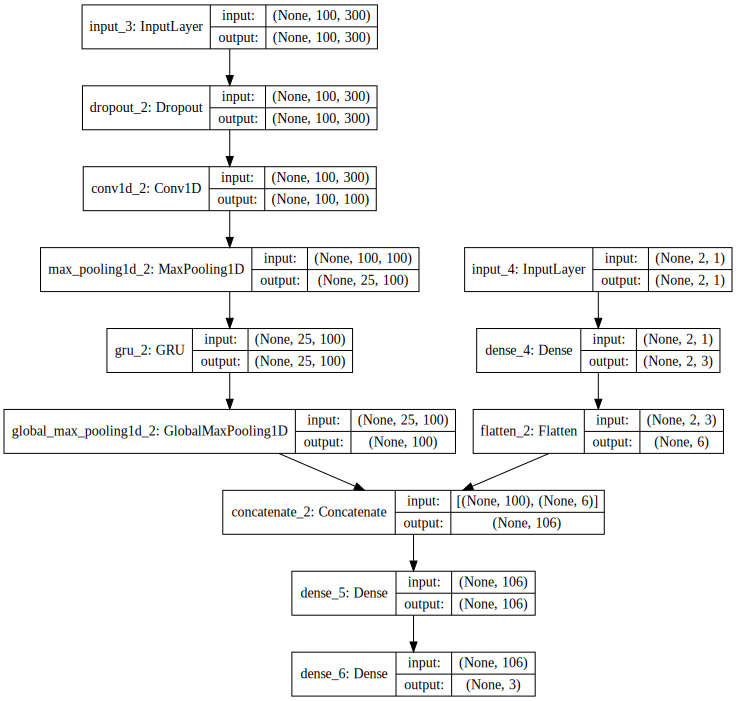

In [13]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))
